In [1]:
import tensorflow as tf
import keras
import PIL
import matplotlib.pyplot as plt
import numpy as np
import shap
import tensorflow.compat.v1.keras.backend as K


print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
print('Notebook running: numpy ', np.__version__)

Notebook running: tensorflow  2.5.0
Notebook running: keras  2.5.0
Notebook running: numpy  1.19.5


In [2]:
#shap GradientExplainer compatibility

tf.compat.v1.disable_eager_execution()

It's possible to choose between VGG16, VGG19, MobileNet, InceptionV3(changing the img size) and the AkinolaVGG16. For this experiments ( recognizing chimpanzee, gorilla and white tiger) AkinolaVGG16 is the most accurate

In [3]:
#Load pretrained model 

# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# model = tf.keras.models.load_model('..\\data\\model')

# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
# model=VGG16()

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
model=VGG19()

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# model=MobileNet()

# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# model=InceptionV3()

574717952/574710816 [==============================] - 4s 0us/step


In [4]:
model.summary()

# #layers with indexes (useful to check which layer inspect)
# for i in range (len(model.layers)):
#   print(i-1,model.layers[i])

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
#loading dataset and image

X,y = shap.datasets.imagenet50()
img = tf.keras.preprocessing.image.load_img("..\\images\\image1.jpg", target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
to_explain = np.reshape(img,[-1,224,224,3]) #reshape for single image


# ##inception size compatibility
# from skimage.transform import resize

# X,y = shap.datasets.imagenet50()
# img = tf.keras.preprocessing.image.load_img("image1.jpg", target_size=(299, 299))
# img = tf.keras.preprocessing.image.img_to_array(img)
# to_explain = np.reshape(img,[-1,299,299,3]) #reshape for single image

# Xinception=np.empty([50,299,299,3]) #resized dataset for InceptionV3
# for i in range(50):
#   Xinception[i]=resize(X[0], (299, 299))
# X=Xinception

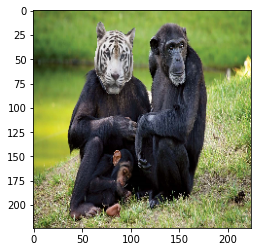

In [6]:
plt.imshow(img/255);

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


40960/35363 [==================================] - 0s 0us/step


<function matplotlib.pyplot.show>

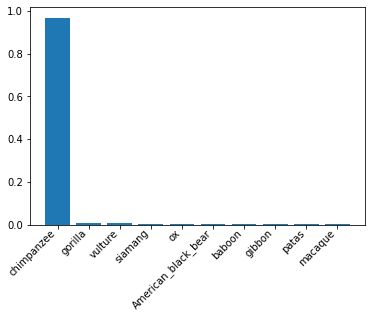

In [7]:
#making prediction
preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),5)
predict=[]

if (model.name=='AkinolaVGG16'):
    class_names={'0':'chimpanzee', '1':'gorilla','2':'white_tiger'}
    preds_data = dict(zip(class_names.values(), preds[0]))
else:
    decoded_preds=decode_predictions(preds,top=10)
    class_names={}
    ind =(-preds[0]).argsort()[:10]
    for i in range (10):
        class_names[str(ind[i])]=decoded_preds[0][i][1]
        predict.append(decoded_preds[0][i][2])
    preds_data = dict(zip(class_names.values(), predict))

#plot results
plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
plt.xticks(range(len(preds_data)), list(preds_data.keys()),rotation=45,va='center_baseline',horizontalalignment='right')
plt.show

In [8]:
# defining shap vals layer method

def shap_vals_layer(n):
  # explain how the input to the "n" layer of the model explains the top two classes
  def map2layer(x, layer):
      feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
      return K.get_session().run(model.layers[layer].input, feed_dict)
  e = shap.GradientExplainer(
      (model.layers[n].input, model.layers[-1].output),
      map2layer(X, n),
      local_smoothing=1 # std dev of smoothing noise
  )

  shap_values,indexes = e.shap_values(map2layer(to_explain, n),ranked_outputs=3)
  return (shap_values,indexes)

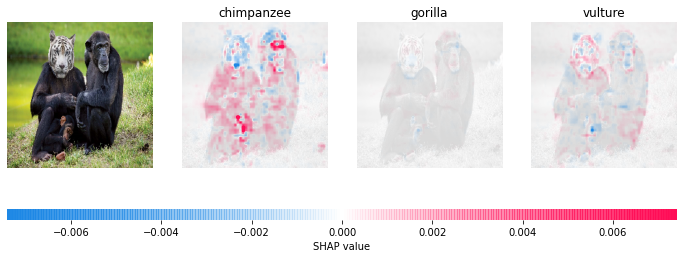

In [9]:
# plot explanation for the 7th layer
value,index=shap_vals_layer(7)
shap.image_plot(value,to_explain,np.vectorize(lambda x: class_names[str(x)])(index))

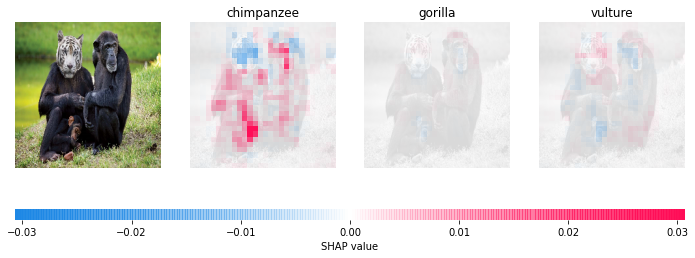

In [10]:
# plot explanation for the 15th layer
value,index=shap_vals_layer(15)
shap.image_plot(value,to_explain,np.vectorize(lambda x: class_names[str(x)])(index))

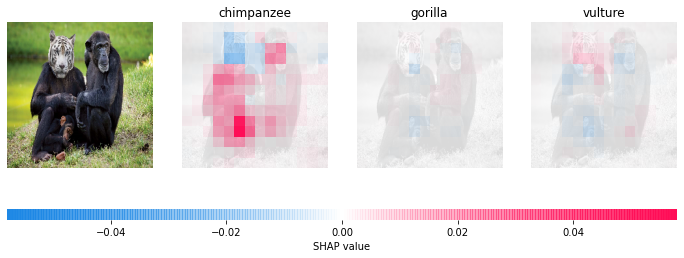

In [11]:
# plot explanation for the 18h layer
value,index=shap_vals_layer(18)
shap.image_plot(value,to_explain,np.vectorize(lambda x: class_names[str(x)])(index))